In [1]:
import pandas as pd
import numpy as np
import utils
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.neighbors import LocalOutlierFactor
from torchvision.datasets import ImageFolder
import sklearn.metrics as metrics
from torchvision import transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import f1_score, classification_report

In [2]:
wacky = False

# Setup

In [3]:
pred_prefix = "../ss/iWildCam_"
target_prefix = "../ss/target_iWildCam_"
unc_out_prefix = "ss/unc_"
pred_out_prefix = "ss/pred_"
num_classes = 182
test_sets=["ind","ood"]
model_ls = ["Resnet18ft7","Resnet50ft3","Resnet101ft2","Resnet50lp3","Resnet101lp2"]
sm_S = model_ls[0]
sm_M = model_ls[1]
sm_L = model_ls[2]
lp_M = model_ls[3]
lp_L = model_ls[4]
duo_SM = "SM_Duo"
duo_SL = "SL_Duo"
lpft_M = "M_LPFT"
lpft_L = "L_LPFT"

Create Ensemble as Baseline:

In [4]:
ens_S_2 = "Resnet18Ens_2"
ens_S_3 = "Resnet18Ens_3"
ens_S_4 = "Resnet18Ens_4"
ens_S_5 = "Resnet18Ens_5"
ens_member_ls = ["Resnet18ft5","Resnet18ft6","Resnet18ft7","Resnet18ft8","Resnet18ft9"]
for testtype in test_sets:
    # Load raw prediction
    S0 = pd.read_csv(f"{pred_prefix}{testtype}_{ens_member_ls[0]}.csv")
    S1 = pd.read_csv(f"{pred_prefix}{testtype}_{ens_member_ls[1]}.csv")
    S2 = pd.read_csv(f"{pred_prefix}{testtype}_{ens_member_ls[2]}.csv")
    S3 = pd.read_csv(f"{pred_prefix}{testtype}_{ens_member_ls[3]}.csv")
    S4 = pd.read_csv(f"{pred_prefix}{testtype}_{ens_member_ls[4]}.csv")
    M_ft = pd.read_csv(f"{pred_prefix}{testtype}_{sm_M}.csv")
    L_ft = pd.read_csv(f"{pred_prefix}{testtype}_{sm_L}.csv")
    M_lp = pd.read_csv(f"{pred_prefix}{testtype}_{lp_M}.csv")
    L_lp = pd.read_csv(f"{pred_prefix}{testtype}_{lp_L}.csv")
    # Softvote to get ensemble predictions
    SE2 = utils.softvote([S0,S1])
    SE3 = utils.softvote([S0,S1,S2])
    SE4 = utils.softvote([S0,S1,S2,S3])
    SE5 = utils.softvote([S0,S1,S2,S3,S4])
    SM_duo = utils.softvote([S0,M_ft])
    SL_duo = utils.softvote([S0,L_ft])
    M_lpft = utils.softvote([M_lp,M_ft])
    L_lpft = utils.softvote([L_lp,L_ft])
    SE2.to_csv(f"{pred_prefix}{testtype}_{ens_S_2}.csv",index=False)
    SE3.to_csv(f"{pred_prefix}{testtype}_{ens_S_3}.csv",index=False)
    SE4.to_csv(f"{pred_prefix}{testtype}_{ens_S_4}.csv",index=False)
    SE5.to_csv(f"{pred_prefix}{testtype}_{ens_S_5}.csv",index=False)
    SM_duo.to_csv(f"{pred_prefix}{testtype}_{duo_SM}.csv",index=False)
    SL_duo.to_csv(f"{pred_prefix}{testtype}_{duo_SL}.csv",index=False)
    M_lpft.to_csv(f"{pred_prefix}{testtype}_{lpft_M}.csv",index=False)
    L_lpft.to_csv(f"{pred_prefix}{testtype}_{lpft_L}.csv",index=False)

{F1, Acc, Brier, Ece, Mce} of raw models 

In [16]:
contestants = ["Resnet18ft5","Resnet18ft6","Resnet18ft7","Resnet18ft8","Resnet18ft9",ens_S_2,ens_S_3,ens_S_4,ens_S_5,sm_M,sm_L,duo_SM,duo_SL,lp_M,lpft_M,lp_L,lpft_L]
contestants = ["Resnet18ft5",ens_S_2,ens_S_3,ens_S_4,ens_S_5,sm_M,sm_L,duo_SM,duo_SL,lp_M,lpft_M,lp_L,lpft_L]

In [17]:
metrics_dict = {
    "Model": [],
    "Test Set": [],
    "F1": [],
    "Brier": [],
    "ECE": [],
    "MCE": []
}
for testtype in test_sets:
    label = pd.read_csv(f"{target_prefix}{testtype}.csv")
    prediction = pd.DataFrame({
        "target": label["target"],
    })
    for method in contestants:
        pred_col_name = f"pred_{method}"
        pred = pd.read_csv(f"{pred_prefix}{testtype}_{method}.csv")
        prediction[pred_col_name] = pred.idxmax(axis=1)
        prediction[pred_col_name] = prediction[pred_col_name].str.extract('(\d+)').astype(int)
        curr_acc = np.mean(prediction[pred_col_name]==prediction["target"])
        report = classification_report(prediction["target"], prediction[pred_col_name], output_dict=True, zero_division=1)
        class_accuracies = [report[key]["recall"] for key in report.keys() if key.isdigit()]
        curr_f1 = f1_score(prediction["target"], prediction[pred_col_name], average='macro')
        curr_brier = utils.brier_score(utils.one_hot(np.array(prediction["target"]),num_classes), utils.softmax(pred))
        curr_ece, curr_mce = utils.calibration(utils.one_hot(np.array(prediction["target"]),num_classes), utils.softmax(pred))
        # print(f"for {method} on {testtype}: Acc={curr_acc:.2f}, F1={curr_f1:.3f}, Brier={curr_brier:.5f}, ECE={curr_ece:.5f}, MCE={curr_mce:.5f}")
        metrics_dict["Model"].append(method)
        metrics_dict["Test Set"].append(testtype)
        metrics_dict["F1"].append(curr_f1)
        metrics_dict["Brier"].append(curr_brier)
        metrics_dict["ECE"].append(curr_ece)
        metrics_dict["MCE"].append(curr_mce)
    prediction.to_csv(f"{pred_out_prefix}{testtype}.csv",index=False)
    # display(prediction.head(1))
metrics_df = pd.DataFrame(metrics_dict)
display(metrics_df)
metrics_df.to_csv(f"{pred_out_prefix}metrics.csv",index=False)

,Model,Test Set,F1,Brier,ECE,MCE
0,Resnet18ft5,ind,0.434209,0.002073,0.144867,0.359074
1,Resnet18ft6,ind,0.432977,0.002095,0.148956,0.347996
2,Resnet18ft7,ind,0.426514,0.002060,0.142927,0.319567
3,Resnet18ft8,ind,0.412150,0.002026,0.143447,0.324862
4,Resnet18ft9,ind,0.385164,0.002122,0.155601,0.361050
5,Resnet18Ens_2,ind,0.440253,0.002038,0.148360,0.362083
6,Resnet18Ens_3,ind,0.441019,0.002009,0.143949,0.404831
7,Resnet18Ens_4,ind,0.435012,0.001986,0.142448,0.369392
8,Resnet18Ens_5,ind,0.421636,0.001992,0.144004,0.352212
9,Resnet50ft3,ind,0.445560,0.001962,0.163429,0.398441


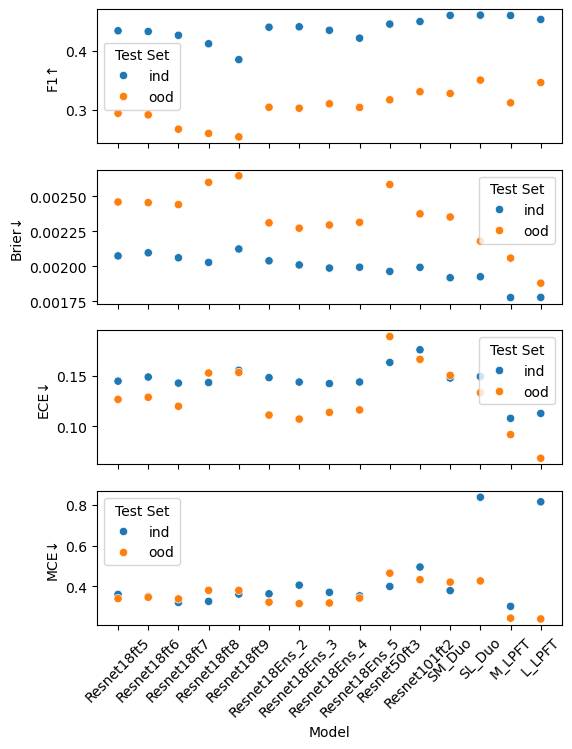

In [9]:
plt.figure(figsize=(6, 8))
metrics = ['F1', 'Brier', 'ECE', 'MCE']
arrows = ["↑","↓","↓","↓"]
for i, metric in enumerate(metrics):
    plt.subplot(4, 1, i + 1)
    sns.scatterplot(data=metrics_df, x='Model', y=metric, hue='Test Set')
    plt.ylabel(metric+arrows[i])
    if i < len(metrics) - 1:
        plt.xlabel('')  # Remove x-label for all plots except the last one
        plt.tick_params(labelbottom=False)  # Hide x-ticks and x-tick labels
    else:
        plt.xlabel('Model')  # Set x-label for the last plot
    plt.xticks(rotation=45)
plt.show()

In [11]:
ens_to_compare = ens_S_3

for testtype in test_sets:
    unc = pd.DataFrame()
    resnet18 = pd.read_csv(f"{pred_prefix}{testtype}_{sm_S}.csv")
    resnet50 = pd.read_csv(f"{pred_prefix}{testtype}_{sm_M}.csv")
    resnet101 = pd.read_csv(f"{pred_prefix}{testtype}_{sm_L}.csv")
    resnet18Ens2 = pd.read_csv(f"{pred_prefix}{testtype}_{ens_S_2}.csv")
    resnet18Ens3 = pd.read_csv(f"{pred_prefix}{testtype}_{ens_S_3}.csv")
    resnet18Ens4 = pd.read_csv(f"{pred_prefix}{testtype}_{ens_S_4}.csv")
    resnet18Ens5 = pd.read_csv(f"{pred_prefix}{testtype}_{ens_S_5}.csv")
    resnet18Ens = pd.read_csv(f"{pred_prefix}{testtype}_{ens_to_compare}.csv")
    SM_duo = pd.read_csv(f"{pred_prefix}{testtype}_{duo_SM}.csv")
    SL_duo = pd.read_csv(f"{pred_prefix}{testtype}_{duo_SL}.csv")
    M_ft = pd.read_csv(f"{pred_prefix}{testtype}_{sm_M}.csv")
    L_ft = pd.read_csv(f"{pred_prefix}{testtype}_{sm_L}.csv")
    M_lp = pd.read_csv(f"{pred_prefix}{testtype}_{lp_M}.csv")
    L_lp = pd.read_csv(f"{pred_prefix}{testtype}_{lp_L}.csv")
    M_lpft = pd.read_csv(f"{pred_prefix}{testtype}_{lpft_M}.csv")
    L_lpft = pd.read_csv(f"{pred_prefix}{testtype}_{lpft_L}.csv")
    
    unc[f"entr_{sm_S}"] = utils.calc_entr_torch(resnet18)
    unc[f"entr_{sm_M}"] = utils.calc_entr_torch(resnet50)
    unc[f"entr_{sm_L}"] = utils.calc_entr_torch(resnet101)
    unc[f"entr_{ens_S_2}"] = utils.calc_entr_torch(resnet18Ens2)
    unc[f"entr_{ens_S_3}"] = utils.calc_entr_torch(resnet18Ens3)
    unc[f"entr_{ens_S_4}"] = utils.calc_entr_torch(resnet18Ens4)
    unc[f"entr_{ens_S_5}"] = utils.calc_entr_torch(resnet18Ens5)
    unc[f"entr_{duo_SM}"] = utils.calc_entr_torch(SM_duo)
    unc[f"entr_{duo_SL}"] = utils.calc_entr_torch(SL_duo)
    unc[f"entr_{lpft_M}"] = utils.calc_entr_torch(M_lpft)
    unc[f"entr_{lpft_L}"] = utils.calc_entr_torch(L_lpft)
    
    unc[f"ce_{sm_L}_{sm_S}"] = utils.calc_cross_entr_torch(resnet101,resnet18)
    unc[f"entr_{sm_L}+ce_{sm_L}_{sm_S}"] = unc[f"entr_{sm_L}"]+unc[f"ce_{sm_L}_{sm_S}"]
    unc[f"ce_{sm_M}_{sm_S}"] = utils.calc_cross_entr_torch(resnet50,resnet18)
    unc[f"entr_{sm_M}+ce_{sm_M}_{sm_S}"] = unc[f"entr_{sm_M}"]+unc[f"ce_{sm_M}_{sm_S}"]
    unc[f"ce_{duo_SM}_{sm_S}"] = utils.calc_cross_entr_torch(SM_duo,resnet18)
    unc[f"entr_{duo_SM}+ce_{duo_SM}_{sm_S}"] = unc[f"entr_{duo_SM}"]+unc[f"ce_{duo_SM}_{sm_S}"]
    unc[f"ce_{duo_SM}_{sm_M}"] = utils.calc_cross_entr_torch(SM_duo,resnet50)
    unc[f"entr_{duo_SM}+ce_{duo_SM}_{sm_M}"] = unc[f"entr_{duo_SM}"]+unc[f"ce_{duo_SM}_{sm_M}"]
    unc[f"entr_{duo_SM}+ce_{sm_M}_{sm_S}"] = unc[f"entr_{duo_SM}"]+unc[f"ce_{sm_M}_{sm_S}"]
    unc[f"ce_{duo_SL}_{sm_L}"] = utils.calc_cross_entr_torch(SL_duo,resnet101)
    unc[f"entr_{duo_SL}+ce_{duo_SL}_{sm_L}"] = unc[f"entr_{duo_SL}"]+unc[f"ce_{duo_SL}_{sm_L}"]
    unc[f"ce_{sm_M}_{lp_M}"] = utils.calc_cross_entr_torch(M_ft,M_lp)
    unc[f"entr_{sm_M}+ce_{sm_M}_{lp_M}"] = unc[f"entr_{sm_M}"]+unc[f"ce_{sm_M}_{lp_M}"]
    unc[f"ce_{sm_L}_{lp_L}"] = utils.calc_cross_entr_torch(L_ft,L_lp)
    unc[f"entr_{sm_L}+ce_{sm_L}_{lp_L}"] = unc[f"entr_{sm_L}"]+unc[f"ce_{sm_L}_{lp_L}"]
    
    if wacky:
        print("Wacky mode on, adding weights...")
        unc[f"entr_{sm_M}+ce_{sm_M}_{sm_S}"] = 0.7*unc[f"entr_{sm_M}"]+0.3*unc[f"ce_{sm_M}_{sm_S}"]
        unc[f"entr_{sm_L}+ce_{sm_L}_{sm_S}"] = 0.85*unc[f"entr_{sm_L}"]+0.15*unc[f"ce_{sm_L}_{sm_S}"]
        unc[f"entr_{duo_SM}+ce_{duo_SM}_{sm_M}"] = 0.8*unc[f"entr_{duo_SM}"]+0.2*unc[f"ce_{duo_SM}_{sm_M}"]
        unc[f"entr_{duo_SL}+ce_{duo_SL}_{sm_L}"] = 0.8*unc[f"entr_{duo_SL}"]+0.2*unc[f"ce_{duo_SL}_{sm_L}"]
    
    unc.to_csv(f"{unc_out_prefix}{testtype}.csv",index=False)

,entr_Resnet18ft7,entr_Resnet50ft3,entr_Resnet101ft2,entr_Resnet18Ens_2,entr_Resnet18Ens_3,entr_Resnet18Ens_4,entr_Resnet18Ens_5,entr_SM_Duo,entr_SL_Duo,entr_M_LPFT,...,entr_SM_Duo+ce_SM_Duo_Resnet18ft7,ce_SM_Duo_Resnet50ft3,entr_SM_Duo+ce_SM_Duo_Resnet50ft3,entr_SM_Duo+ce_Resnet50ft3_Resnet18ft7,ce_SL_Duo_Resnet101ft2,entr_SL_Duo+ce_SL_Duo_Resnet101ft2,ce_Resnet50ft3_Resnet50lp3,entr_Resnet50ft3+ce_Resnet50ft3_Resnet50lp3,ce_Resnet101ft2_Resnet101lp2,entr_Resnet101ft2+ce_Resnet101ft2_Resnet101lp2
0,0.01465,0.003841,0.007743,0.007492,0.007463,0.00913,0.0061,0.009328,0.013132,0.035347,...,0.020208,0.00978,0.019108,0.014402,0.013407,0.026539,0.133311,0.137152,0.337199,0.344942


,entr_Resnet18ft7,entr_Resnet50ft3,entr_Resnet101ft2,entr_Resnet18Ens_2,entr_Resnet18Ens_3,entr_Resnet18Ens_4,entr_Resnet18Ens_5,entr_SM_Duo,entr_SL_Duo,entr_M_LPFT,...,entr_SM_Duo+ce_SM_Duo_Resnet18ft7,ce_SM_Duo_Resnet50ft3,entr_SM_Duo+ce_SM_Duo_Resnet50ft3,entr_SM_Duo+ce_Resnet50ft3_Resnet18ft7,ce_SL_Duo_Resnet101ft2,entr_SL_Duo+ce_SL_Duo_Resnet101ft2,ce_Resnet50ft3_Resnet50lp3,entr_Resnet50ft3+ce_Resnet50ft3_Resnet50lp3,ce_Resnet101ft2_Resnet101lp2,entr_Resnet101ft2+ce_Resnet101ft2_Resnet101lp2
0,0.545213,0.088538,0.561082,0.574981,0.560601,0.260575,0.226271,0.76426,0.392669,1.053282,...,2.734737,1.515313,2.279573,3.150724,0.438496,0.831164,3.350131,3.438669,0.962739,1.523821


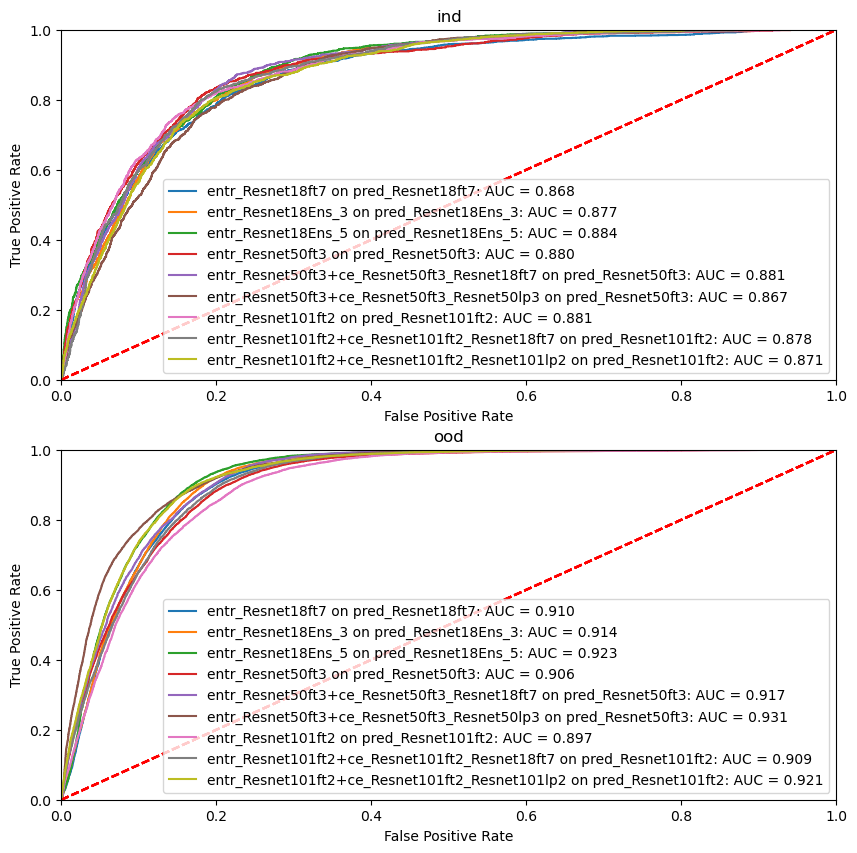

In [12]:
fig, axes = plt.subplots(2, 1, figsize=(10,10))
for i,testtype in enumerate(test_sets):
    ax = axes[i]
    ax.set_title(testtype)
    pred_df = pd.read_csv(f"{pred_out_prefix}{testtype}.csv")
    unc_df = pd.read_csv(f"{unc_out_prefix}{testtype}.csv")
    # display(pred_df.head(1))
    display(unc_df.head(1))
    utils.auroc(pred_df, unc_df, f"pred_{sm_S}", "target", f"entr_{sm_S}", ax)
    utils.auroc(pred_df, unc_df, f"pred_{ens_S_3}", "target", f"entr_{ens_S_3}", ax)
    utils.auroc(pred_df, unc_df, f"pred_{ens_S_5}", "target", f"entr_{ens_S_5}", ax)
    utils.auroc(pred_df, unc_df, f"pred_{sm_M}", "target", f"entr_{sm_M}", ax)
    utils.auroc(pred_df, unc_df, f"pred_{sm_M}", "target", f"entr_{sm_M}+ce_{sm_M}_{sm_S}", ax)
    utils.auroc(pred_df, unc_df, f"pred_{sm_M}", "target", f"entr_{sm_M}+ce_{sm_M}_{lp_M}", ax)
    utils.auroc(pred_df, unc_df, f"pred_{sm_L}", "target", f"entr_{sm_L}", ax)
    utils.auroc(pred_df, unc_df, f"pred_{sm_L}", "target", f"entr_{sm_L}+ce_{sm_L}_{sm_S}", ax)
    utils.auroc(pred_df, unc_df, f"pred_{sm_L}", "target", f"entr_{sm_L}+ce_{sm_L}_{lp_L}", ax)
    # utils.auroc(pred_df, unc_df, f"pred_{duo_SM}", "target", f"entr_{duo_SM}", ax)
    # utils.auroc(pred_df, unc_df, f"pred_{duo_SM}", "target", f"entr_{duo_SM}+ce_{duo_SM}_{sm_M}", ax)
    # utils.auroc(pred_df, unc_df, f"pred_{duo_SL}", "target", f"entr_{duo_SL}", ax)
    # utils.auroc(pred_df, unc_df, f"pred_{duo_SL}", "target", f"entr_{duo_SL}+ce_{duo_SL}_{sm_L}", ax)

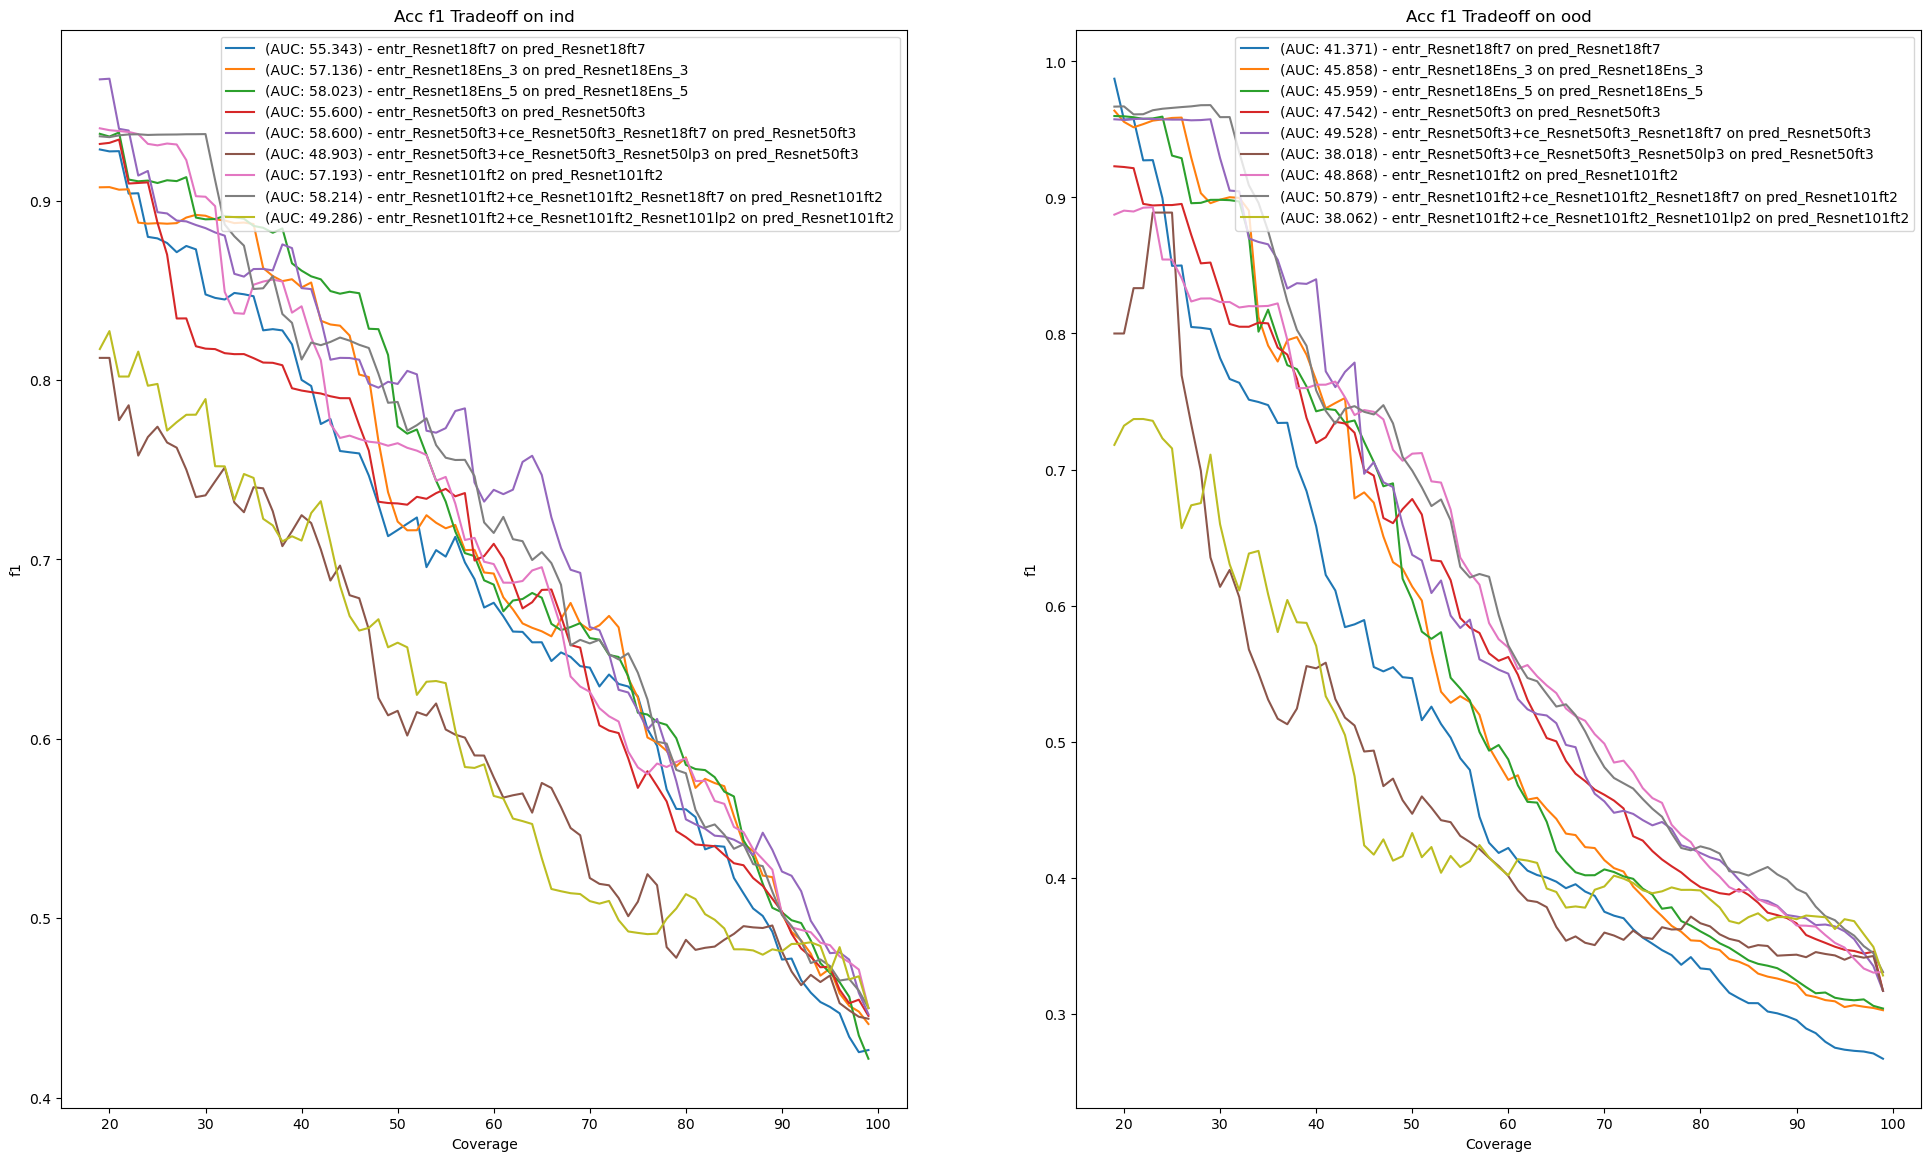

In [13]:
metric_to_plot = "f1" #["acc","f1"]
cov_range = np.arange(19,100)
fig, axes = plt.subplots(1, 2, figsize=(24, 14))
for i,testtype in enumerate(test_sets):
    ax = axes[i]
    ax.set_title(f"Acc {metric_to_plot} Tradeoff on {testtype}")
    pred_df = pd.read_csv(f"{pred_out_prefix}{testtype}.csv")
    unc_df = pd.read_csv(f"{unc_out_prefix}{testtype}.csv")
    rank=utils.get_rank(unc_df)
    utils.acc_cov_tradeoff(pred_df, f"pred_{sm_S}", "target", f"entr_{sm_S}", rank, ax, cov_range,metric_to_plot)
    utils.acc_cov_tradeoff(pred_df, f"pred_{ens_to_compare}", "target", f"entr_{ens_to_compare}", rank, ax, cov_range,metric_to_plot)
    utils.acc_cov_tradeoff(pred_df, f"pred_{ens_S_5}", "target", f"entr_{ens_S_5}", rank, ax, cov_range,metric_to_plot)
    utils.acc_cov_tradeoff(pred_df, f"pred_{sm_M}", "target", f"entr_{sm_M}", rank, ax, cov_range,metric_to_plot)
    utils.acc_cov_tradeoff(pred_df, f"pred_{sm_M}", "target", f"entr_{sm_M}+ce_{sm_M}_{sm_S}", rank, ax, cov_range,metric_to_plot)
    utils.acc_cov_tradeoff(pred_df, f"pred_{sm_M}", "target", f"entr_{sm_M}+ce_{sm_M}_{lp_M}", rank, ax, cov_range,metric_to_plot)
    utils.acc_cov_tradeoff(pred_df, f"pred_{sm_L}", "target", f"entr_{sm_L}", rank, ax, cov_range,metric_to_plot)
    utils.acc_cov_tradeoff(pred_df, f"pred_{sm_L}", "target", f"entr_{sm_L}+ce_{sm_L}_{sm_S}", rank, ax, cov_range,metric_to_plot)
    utils.acc_cov_tradeoff(pred_df, f"pred_{sm_L}", "target", f"entr_{sm_L}+ce_{sm_L}_{lp_L}", rank, ax, cov_range,metric_to_plot)
    
    # utils.acc_cov_tradeoff(pred_df, f"pred_{duo_SM}", "target", f"entr_{duo_SM}", rank, ax, cov_range,metric_to_plot)
    # utils.acc_cov_tradeoff(pred_df, f"pred_{duo_SM}", "target", f"entr_{duo_SM}+ce_{duo_SM}_{sm_M}", rank, ax, cov_range,metric_to_plot)
    # utils.acc_cov_tradeoff(pred_df, f"pred_{duo_SL}", "target", f"entr_{duo_SL}", rank, ax, cov_range,metric_to_plot)
    # utils.acc_cov_tradeoff(pred_df, f"pred_{duo_SL}", "target", f"entr_{duo_SL}+ce_{duo_SL}_{sm_L}", rank, ax, cov_range,metric_to_plot)

In [11]:
unc1 = f"entr_{sm_M}"
unc2 = f"entr_{sm_M}+ce_{sm_M}_{sm_S}"
evaluatee = f"pred_{sm_M}"
quantile=88

In [12]:
def descrimination_power_plot(pred_df,unc_df,quantile,unc1,unc2,evaluatee,ax,hue="correctness"):
    unc_1_threshold = np.percentile(a=unc_df[unc1],q=quantile)
    unc_2_threshold = np.percentile(a=unc_df[unc2],q=quantile)
    unc_1_edge = pred_df[(unc_df[unc1] > unc_1_threshold) & (unc_df[unc2] < unc_2_threshold)]
    unc_df[f"{unc1}_edge"]=(unc_df[unc1] > unc_1_threshold) & (unc_df[unc2] < unc_2_threshold)
    unc_2_edge = pred_df[(unc_df[unc2] > unc_2_threshold) & (unc_df[unc1] < unc_1_threshold)]
    unc_df[f"{unc2}_edge"]=(unc_df[unc2] > unc_2_threshold) & (unc_df[unc1] < unc_1_threshold)
    unc_1_unc_2_joint = pred_df[(unc_df[unc1] >= unc_1_threshold) & (unc_df[unc2] >= unc_2_threshold)]
    unc_df[f"{unc1}_{unc2}_joint"]=(unc_df[unc1] >= unc_1_threshold) & (unc_df[unc2] >= unc_2_threshold)
    covered_unc_1 = pred_df[(unc_df[unc1] <= unc_1_threshold)]
    covered_unc_2 = pred_df[(unc_df[unc2] <= unc_2_threshold)]
    
    unc_1_edge_acc = np.mean(unc_1_edge[evaluatee]==unc_1_edge["target"])
    unc_2_edge_acc = np.mean(unc_2_edge[evaluatee]==unc_2_edge["target"])
    unc_1_unc_2_joint_acc = np.mean(unc_1_unc_2_joint[evaluatee]==unc_1_unc_2_joint["target"])
    covered_acc_unc_1 = np.mean(covered_unc_1[evaluatee]==covered_unc_1["target"])
    covered_acc_unc_2 = np.mean(covered_unc_2[evaluatee]==covered_unc_2["target"])
    if(hue=="correctness"):
        unc_df[hue] = pred_df[evaluatee]==pred_df["target"]
    else:
        unc_df[hue] = pred_df[hue]
    sns.scatterplot(data=unc_df,x=unc1,y=unc2,hue=hue,ax=ax)
    ax.axvline(unc_1_threshold,)
    ax.axhline(unc_2_threshold) 
    size_unc1_edge, size_unc2_edge, size_unc1_2_joint, coverage_unc_1, coverage_unc_2 = unc_1_edge.shape[0], unc_2_edge.shape[0], unc_1_unc_2_joint.shape[0], covered_unc_1.shape[0]/pred_df.shape[0], covered_unc_2.shape[0]/pred_df.shape[0]
    ax.text(0.95, 0.20, f"n={size_unc1_edge}", transform=ax.transAxes, ha='right', va='top')
    ax.text(0.95, 0.15, f"acc={unc_1_edge_acc:.2f}", transform=ax.transAxes, ha='right', va='top')
    ax.text(0.15, 0.95, f"n={size_unc2_edge}", transform=ax.transAxes, ha='right', va='top')
    ax.text(0.15, 0.9, f"acc={unc_2_edge_acc:.2f}", transform=ax.transAxes, ha='right', va='top')
    ax.text(0.85, 0.95, f"n={size_unc1_2_joint}", transform=ax.transAxes, ha='right', va='top')
    ax.text(0.85, 0.9, f"acc={unc_1_unc_2_joint_acc:.2f}", transform=ax.transAxes, ha='right', va='top')
    ax.text(0.3, 0.25, f"[with unc1 split] \ncoverage={coverage_unc_1:.2f}", transform=ax.transAxes, ha='right', va='top')
    ax.text(0.3, 0.2, f"acc={covered_acc_unc_1:.3f}", transform=ax.transAxes, ha='right', va='top')
    ax.text(0.35, 0.6, f"[with unc2 split] \ncoverage={coverage_unc_2:.2f}", transform=ax.transAxes, ha='right', va='top')
    ax.text(0.35, 0.55, f"acc={covered_acc_unc_2:.3f}", transform=ax.transAxes, ha='right', va='top')
plt.tight_layout()

<Figure size 640x480 with 0 Axes>

ind
ood


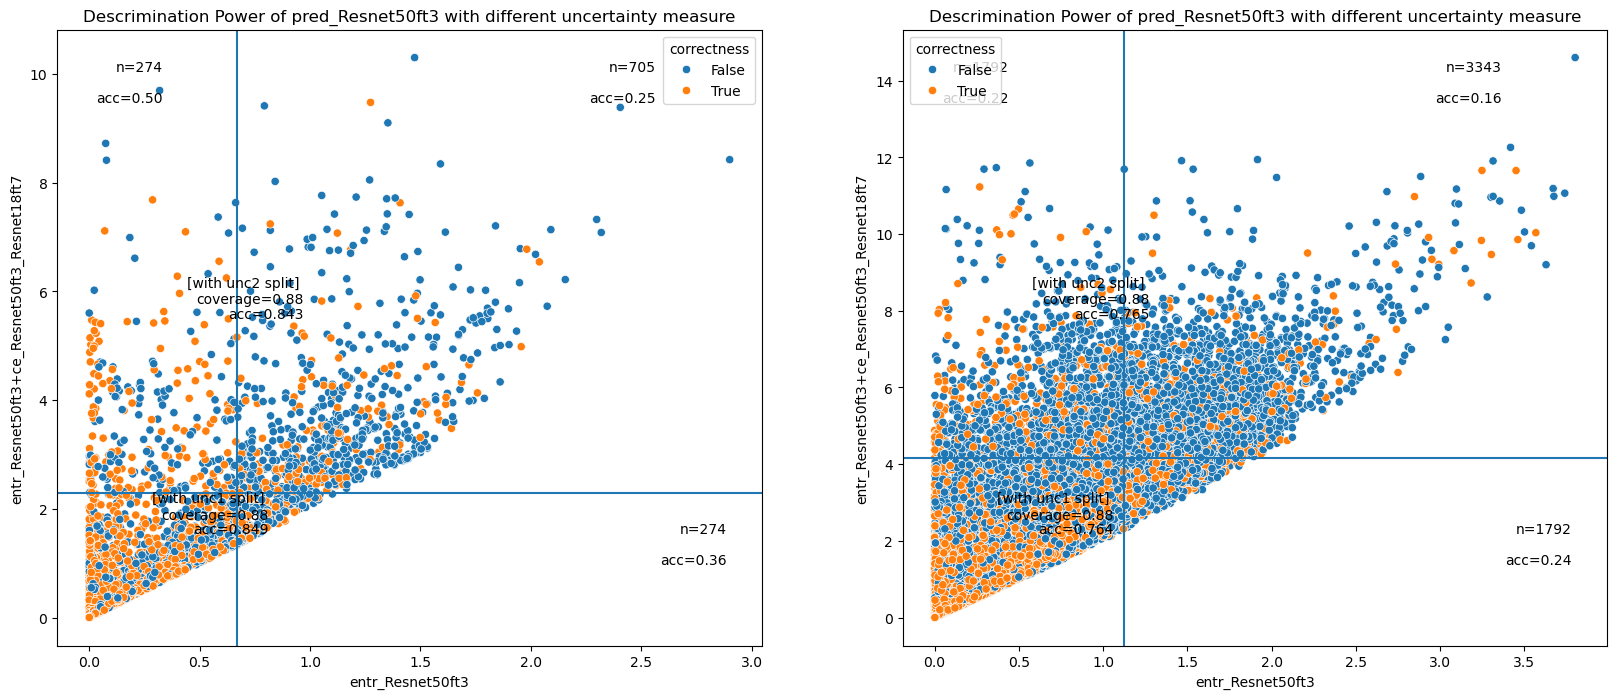

In [13]:
fig, axes = plt.subplots(1,2, figsize=(20, 8))
for i,testtype in enumerate(test_sets):
    print(testtype)
    ax = axes[i]
    ax.set_title(f"Descrimination Power of {evaluatee} with different uncertainty measure")
    pred_df = pd.read_csv(f"{pred_out_prefix}{testtype}.csv")
    unc_df = pd.read_csv(f"{unc_out_prefix}{testtype}.csv")
    descrimination_power_plot(pred_df,unc_df,quantile,unc1,unc2,evaluatee,ax,hue="correctness")
    

In [14]:
def ood_detection_plot(pred_df,unc_df,quantile,unc1,unc2,evaluatee,ax,hue="correctness"):
    unc_1_threshold = np.percentile(a=unc_df[unc1],q=quantile)
    unc_2_threshold = np.percentile(a=unc_df[unc2],q=quantile)
    unc_1_edge = pred_df[(unc_df[unc1] > unc_1_threshold) & (unc_df[unc2] < unc_2_threshold)]
    unc_df[f"{unc1}_edge"]=(unc_df[unc1] > unc_1_threshold) & (unc_df[unc2] < unc_2_threshold)
    unc_2_edge = pred_df[(unc_df[unc2] > unc_2_threshold) & (unc_df[unc1] < unc_1_threshold)]
    unc_df[f"{unc2}_edge"]=(unc_df[unc2] > unc_2_threshold) & (unc_df[unc1] < unc_1_threshold)
    unc_1_unc_2_joint = pred_df[(unc_df[unc1] >= unc_1_threshold) & (unc_df[unc2] >= unc_2_threshold)]
    unc_df[f"{unc1}_{unc2}_joint"]=(unc_df[unc1] >= unc_1_threshold) & (unc_df[unc2] >= unc_2_threshold)
    covered_unc_1 = pred_df[(unc_df[unc1] <= unc_1_threshold)]
    covered_unc_2 = pred_df[(unc_df[unc2] <= unc_2_threshold)]
    
    unc_1_edge_acc = np.mean(unc_1_edge[evaluatee]==unc_1_edge["target"])
    unc_2_edge_acc = np.mean(unc_2_edge[evaluatee]==unc_2_edge["target"])
    unc_1_unc_2_joint_acc = np.mean(unc_1_unc_2_joint[evaluatee]==unc_1_unc_2_joint["target"])
    covered_acc_unc_1 = np.mean(covered_unc_1[evaluatee]==covered_unc_1["target"])
    covered_acc_unc_2 = np.mean(covered_unc_2[evaluatee]==covered_unc_2["target"])
    unc_1_edge_oac_sum = np.sum(unc_1_edge[hue]=="ood and cor")
    unc_1_edge_oai_sum = np.sum(unc_1_edge[hue]=="ood and inc")
    unc_1_edge_iac_sum = np.sum(unc_1_edge[hue]=="ind and cor")
    unc_1_edge_iai_sum = np.sum(unc_1_edge[hue]=="ind and inc")
    unc_2_edge_oac_sum = np.sum(unc_2_edge[hue]=="ood and cor")
    unc_2_edge_oai_sum = np.sum(unc_2_edge[hue]=="ood and inc")
    unc_2_edge_iac_sum = np.sum(unc_2_edge[hue]=="ind and cor")
    unc_2_edge_iai_sum = np.sum(unc_2_edge[hue]=="ind and inc")
    if(hue=="correctness"):
        unc_df[hue] = pred_df[evaluatee]==pred_df["target"]
    else:
        unc_df[hue] = pred_df[hue]
    sns.scatterplot(data=unc_df,x=unc1,y=unc2,hue=hue,ax=ax)
    ax.axvline(unc_1_threshold,)
    ax.axhline(unc_2_threshold) 
    size_unc1_edge, size_unc2_edge, size_unc1_2_joint, coverage_unc_1, coverage_unc_2 = unc_1_edge.shape[0], unc_2_edge.shape[0], unc_1_unc_2_joint.shape[0], covered_unc_1.shape[0]/pred_df.shape[0], covered_unc_2.shape[0]/pred_df.shape[0]
    ax.text(0.95, 0.18, f"n={size_unc1_edge}", transform=ax.transAxes, ha='right', va='top')
    ax.text(0.95, 0.15, f"acc={unc_1_edge_acc:.2f} \n #o&c={unc_1_edge_oac_sum} \n #o&i={unc_1_edge_oai_sum}", transform=ax.transAxes, ha='right', va='top')
    ax.text(0.15, 0.83, f"n={size_unc2_edge}", transform=ax.transAxes, ha='right', va='top')
    ax.text(0.15, 0.8, f"acc={unc_2_edge_acc:.2f} \n #o&c={unc_2_edge_oac_sum} \n #o&i={unc_2_edge_oai_sum}", transform=ax.transAxes, ha='right', va='top')
    ax.text(0.85, 0.93, f"n={size_unc1_2_joint}", transform=ax.transAxes, ha='right', va='top')
    ax.text(0.85, 0.9, f"acc={unc_1_unc_2_joint_acc:.2f}", transform=ax.transAxes, ha='right', va='top')
    ax.text(0.3, 0.15, f"[with unc1 split] \ncoverage={coverage_unc_1:.2f}", transform=ax.transAxes, ha='right', va='top')
    ax.text(0.3, 0.1, f"acc={covered_acc_unc_1:.3f}", transform=ax.transAxes, ha='right', va='top')
    ax.text(0.25, 0.6, f"[with unc2 split] \ncoverage={coverage_unc_2:.2f}", transform=ax.transAxes, ha='right', va='top')
    ax.text(0.25, 0.55, f"acc={covered_acc_unc_2:.3f}", transform=ax.transAxes, ha='right', va='top')
plt.tight_layout()

<Figure size 640x480 with 0 Axes>

pred_df_ind.shape=(8154, 15) || pred_df_ood.shape=(42791, 15) || pred_df_combined.shape=(50945, 15) || unc_df_combined.shape=(50945, 20)


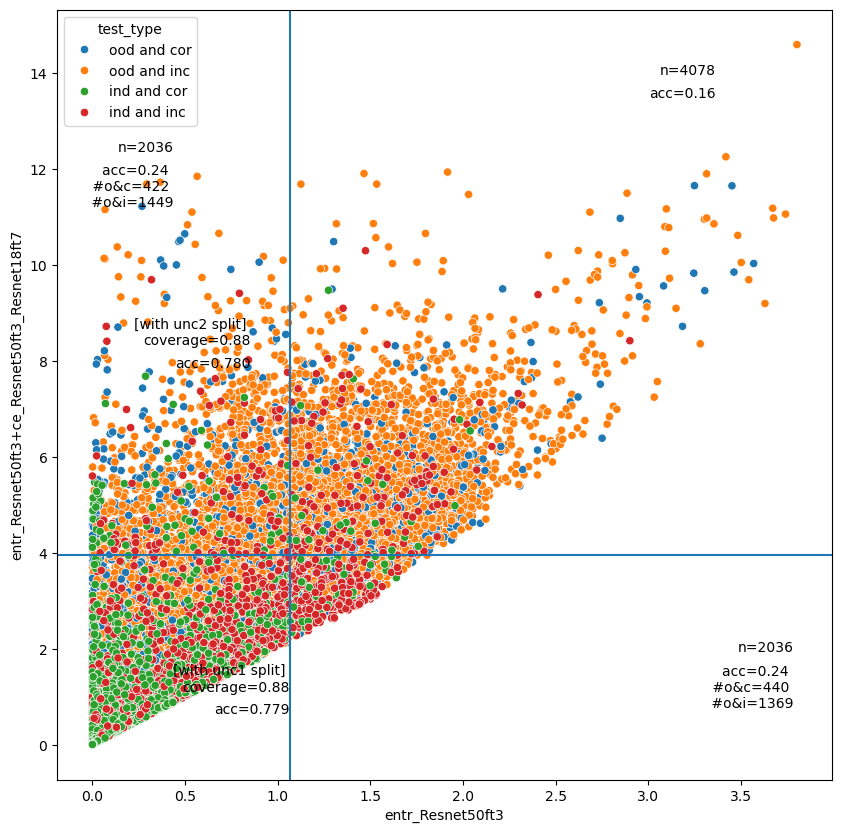

In [15]:
fig, axes = plt.subplots(1,1, figsize=(10, 10))
pred_df_ind = pd.read_csv(f"{pred_out_prefix}ind.csv")
unc_df_ind = pd.read_csv(f"{unc_out_prefix}ind.csv")
pred_df_ood = pd.read_csv(f"{pred_out_prefix}ood.csv")
unc_df_ood = pd.read_csv(f"{unc_out_prefix}ood.csv")
pred_df_ind["test_type"] = np.where(pred_df_ind[evaluatee] == pred_df_ind["target"], "ind and cor", "ind and inc")
pred_df_ood["test_type"] = np.where(pred_df_ood[evaluatee] == pred_df_ood["target"], "ood and cor", "ood and inc")
pred_df_combined = pd.concat([pred_df_ood,pred_df_ind,],ignore_index=True)
unc_df_combined = pd.concat([unc_df_ood,unc_df_ind,],ignore_index=True)
print(f"{pred_df_ind.shape=} || {pred_df_ood.shape=} || {pred_df_combined.shape=} || {unc_df_combined.shape=}")
ood_detection_plot(pred_df_combined,unc_df_combined,quantile,unc1,unc2,evaluatee,axes,"test_type")

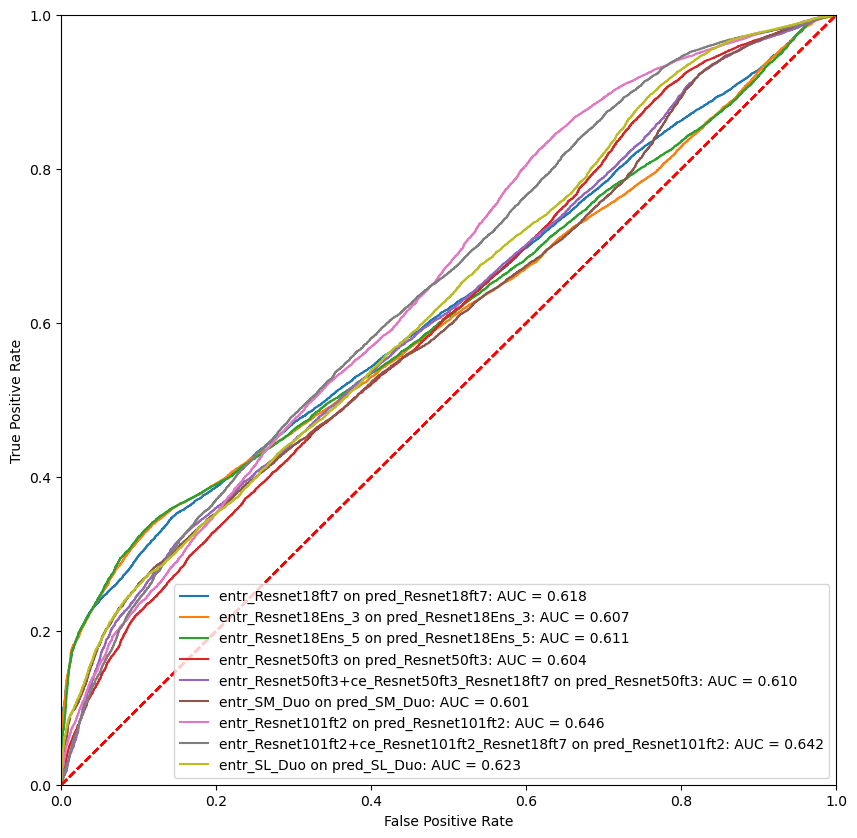

In [16]:
fig, axes = plt.subplots(1,1, figsize=(10, 10))

utils.auroc_ood(pred_df_combined, unc_df_combined, f"pred_{sm_S}", f"entr_{sm_S}", axes)
utils.auroc_ood(pred_df_combined, unc_df_combined, f"pred_{ens_S_3}", f"entr_{ens_S_3}", axes)
utils.auroc_ood(pred_df_combined, unc_df_combined, f"pred_{ens_S_5}", f"entr_{ens_S_5}", axes)
utils.auroc_ood(pred_df_combined, unc_df_combined, f"pred_{sm_M}", f"entr_{sm_M}", axes)
utils.auroc_ood(pred_df_combined, unc_df_combined, f"pred_{sm_M}", f"entr_{sm_M}+ce_{sm_M}_{sm_S}", axes)
utils.auroc_ood(pred_df_combined, unc_df_combined, f"pred_{duo_SM}", f"entr_{duo_SM}", axes)
utils.auroc_ood(pred_df_combined, unc_df_combined, f"pred_{sm_L}", f"entr_{sm_L}", axes)
utils.auroc_ood(pred_df_combined, unc_df_combined, f"pred_{sm_L}", f"entr_{sm_L}+ce_{sm_L}_{sm_S}", axes)
utils.auroc_ood(pred_df_combined, unc_df_combined, f"pred_{duo_SL}", f"entr_{duo_SL}", axes)